In [185]:
import numpy as np
import escnn.gspaces as gspaces
import escnn.nn as enn
import escnn
import torch
import torch.nn as nn
import torch.optim as optim

import random
import math
import time
import tqdm
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns
from sympy.combinatorics import Permutation, PermutationGroup

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

PATH = os.getcwd()

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.set_default_device(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0),1), 'B')
    print('Reserved: ', round(torch.cuda.memory_reserved(0),1), 'B')
    print()
    torch.set_default_device('cuda')

# test
T = torch.randn(1, 4).to(device)
print(T)
print('Allocated:', round(torch.cuda.memory_allocated(0),1), 'B')

Using device: cpu
tensor([[ 0.6026, -0.2325, -1.6285, -0.7633]])
Allocated: 0 B


### Generate Table of All Possible States Indexed in Lexigraphical Order

In [187]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = np.concatenate((np.ones(n-n0),-1*np.ones(n0))).astype(int)
    for i in range(0,N):
        states.append(np.copy(state))
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return torch.tensor(states, dtype=torch.float, requires_grad=True)

### Generate Adjacency Matrices

In [188]:
class Node:
    def __init__(self, position, xadj, yadj):
        self.position = position
        self.xadj = xadj
        self.yadj = yadj
    
    def __str__(self):
        return f"{self.position} {self.xadj} {self.yadj}"

In [189]:
def squareAdjacencyList(a,b): # constructs a periodic adjacency graph with width a and height b
    nodes = []
    for j in range(0,b):
        for i in range(0,a):
            xadj = [[(i-1) % a,j],[(i+1) % a,j]]
            yadj = [[i,(j-1) % b],[i,(j+1) % b]]
            nodes.append(Node([[i,j]],xadj,yadj))

    return nodes

### First Neighbors Adjacency Matrix

In [208]:
def firstneighbors(a,b): 
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False
            for xptr in nodes[i].xadj:
                if xptr in nodes[j].position:
                    flag = True
            for yptr in nodes[i].yadj:
                if yptr in nodes[j].position:
                    flag = True
            if flag:
                J[i][j] = 1
                J[j][i] = 1
        
    return torch.tensor(J, dtype=torch.float, requires_grad=True)

### Second Neighbors (Euclidean) Adjacency Matrix

In [191]:
def secondneighbors(a,b):
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False

            for xptr in nodes[i].xadj:
                try:
                    for k in range(0,N):
                        if xptr in nodes[k].position:
                            intermediate = k
                    for yptr in nodes[intermediate].yadj:
                        if yptr in nodes[j].position:
                            flag = True
                except UnboundLocalError:
                    pass

            if flag:
                J[i][j] = 1
                J[j][i] = 1

    return torch.tensor(J, dtype=torch.float, requires_grad=True)

### Model Parameters

In [192]:
a = 4 # x-range of supercell
b = 4 # y-range of supercell
N1 = firstneighbors(a,b)
N2 = secondneighbors(a,b)
n = a*b # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

stateTable = generateStateTable(n,n0,N)

In [193]:
def stateValBin(state):
    sum = 0
    for i in range(len(state)):
        if state[i] == 1:
            sum += 2**i
    return sum

def searchState(state):
    high = N-1
    low = 0
    while True:
        mid = math.floor((high+low)/2)
        if np.array_equal(state,stateTable[mid]):
            return mid
        elif stateValBin(state) > stateValBin(stateTable[mid]):
            low = mid+1
        else:
            high = mid-1

### Define G-CNN Model

In [194]:
# Define the group and input/output types
gspace = gspaces.rot2dOnR2(N=4)  # Example for rotation group of order 4 (D4)
input_type = enn.FieldType(gspace, [gspace.trivial_repr])  # Scalar fields
output_type = enn.FieldType(gspace, [gspace.trivial_repr])  # Single scalar output

In [195]:
class PeriodicConvLayer(enn.EquivariantModule):
    def __init__(self, in_type, out_type, kernel_size):
        super(PeriodicConvLayer, self).__init__()
        
        self.kernel_size = kernel_size
        self.conv = enn.R2Conv(in_type, out_type, kernel_size, padding=0)
        
    def periodic_padding(self, x, padding):
        return torch.nn.functional.pad(x, padding, mode='circular')
        
    def forward(self, x):
        padding = self.kernel_size // 2
        x = self.periodic_padding(x.tensor, (padding, padding, padding, padding))
        x = enn.GeometricTensor(x, self.conv.in_type)
        return self.conv(x)
    
    def evaluate_output_shape(self, input_shape):
        padding = self.kernel_size // 2
        return self.conv.evaluate_output_shape(input_shape[:-2] + (input_shape[-2] + 2 * padding, input_shape[-1] + 2 * padding))

In [196]:
# Define the network
class GCNN(nn.Module):
    def __init__(self):
        super(GCNN, self).__init__()
        
        self.block1 = PeriodicConvLayer(input_type, enn.FieldType(gspace, 8*[gspace.regular_repr]), kernel_size=4)
        self.block2 = PeriodicConvLayer(enn.FieldType(gspace, 8*[gspace.regular_repr]), enn.FieldType(gspace, 16*[gspace.regular_repr]), kernel_size=4)
        self.block3 = PeriodicConvLayer(enn.FieldType(gspace, 16*[gspace.regular_repr]), output_type, kernel_size=4)
        self.pool = enn.PointwiseAvgPoolAntialiased(output_type, sigma=0.66, stride=1)

        self.gpool = enn.GroupPooling(output_type)
        
        self.linear = nn.Linear(49, 1)
        
    def forward(self, x):
        x = enn.GeometricTensor(x, input_type)
        x = self.block1(x)
        x = nn.functional.relu(x.tensor)
        x = enn.GeometricTensor(x, self.block2.conv.in_type)
        x = self.block2(x)
        x = nn.functional.relu(x.tensor)
        x = enn.GeometricTensor(x, self.block3.conv.in_type)
        x = self.block3(x)
        x = self.pool(x)
        x = self.gpool(x)
        x = torch.flatten(x.tensor, 1)
        x = self.linear(x)
        return x

### Build Model

In [197]:
model = GCNN().to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)

GCNN(
  (block1): PeriodicConvLayer(
    (conv): R2Conv([C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)], [C4_on_R2[(None, 4)]: {regular (x8)}(32)], kernel_size=4, stride=1)
  )
  (block2): PeriodicConvLayer(
    (conv): R2Conv([C4_on_R2[(None, 4)]: {regular (x8)}(32)], [C4_on_R2[(None, 4)]: {regular (x16)}(64)], kernel_size=4, stride=1)
  )
  (block3): PeriodicConvLayer(
    (conv): R2Conv([C4_on_R2[(None, 4)]: {regular (x16)}(64)], [C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)], kernel_size=4, stride=1)
  )
  (pool): PointwiseAvgPoolAntialiased2D()
  (gpool): GroupPooling([C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)])
  (linear): Linear(in_features=49, out_features=1, bias=True)
)

### Energy Estimation Sampling

In [198]:
def findAdjStates(initState): ### takes some basis state and returns a list of all other states that have a nonzero Hamiltonian with it
    otherStates = []
    
    for i in range(n-1):
        for j in range(i+1,n):
            if (N1[i][j] != 0 or N2[i][j] !=0) and initState[i]*initState[j] == -1:
                tempState = initState.clone()
                tempState[i],tempState[j] = initState[j],initState[i]
                otherStates.append(tempState)                

    return otherStates
    
def computeExplicitHamEntry(state1,state2,J1,J2,diagonal):
    sum = 0.0
    if diagonal:
        for k in range(0,n-1):
            for l in range(k+1,n):
                if (N1[k][l] != 0):
                    sum += J1*state1[k]*state2[l]
                if (N2[k][l] != 0):
                    sum += J2*state1[k]*state2[l]          
    else:
        tempState = state1 * state2
        if (torch.count_nonzero(tempState == -1) == 2):
            indices = np.where(tempState == -1)
            e,f = indices[0][0],indices[0][1]
            if (N1[e][f] != 0):
                sum += 2*J1
            if (N2[e][f] != 0):
                sum += 2*J2
    
    return torch.tensor(sum,dtype=torch.float,requires_grad=True)

def locEnergy(model,initState,coeff,J1,J2):
    sum = torch.tensor(0.0,dtype=torch.float,requires_grad=True)
    others = findAdjStates(initState)
    for x in others:
        c_x = model(torch.tensor(x.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
        H_x = computeExplicitHamEntry(initState,x,J1,J2,False)
        sum = torch.add(sum,c_x*H_x)
    sum /= coeff
    sum = torch.add(sum,computeExplicitHamEntry(initState,initState,J1,J2,True))
    return sum

def metropolis(model,initState,coeff):
    proposedState = torch.tensor([1]*(n-n0)+[-1]*n0, dtype=torch.float, requires_grad=True)
    proposedState = proposedState[torch.randperm(proposedState.size(0))]
    newCoeff = model(torch.tensor(proposedState.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
    acceptanceProb = min(1,(newCoeff/coeff)**2)
    bernTrial = torch.bernoulli(torch.tensor([acceptanceProb],dtype=torch.float, requires_grad=True))
    if bernTrial == 1:
        return proposedState
    else:
        return initState

def sampleEnergy(model,batchSize,J1,J2): ### takes in basis state index
    ignore = 10 # number of MCMC steps to ignore (in order to reduce correlation)
    state = torch.tensor([1]*(n-n0)+[-1]*n0, dtype=torch.float, requires_grad=True)
    state = state[torch.randperm(state.size(0))]
    for i in range(ignore):
        c = model(torch.tensor(state.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
        state = metropolis(model,state,c)

    sum = 0.0
    for step in range(batchSize):
        c = model(torch.tensor(state.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
        sum += locEnergy(model,state,c,J1,J2)
        state = metropolis(model,state,c)
    
    return sum / batchSize

### Train Model

In [199]:
H = sparse.load_npz(PATH +'/'+str(a)+'x'+str(b)+'hamiltonian.npz')
H = H.toarray()
H = torch.tensor(H,dtype=torch.float,requires_grad=True)

def trainModel(J1, J2, batchSize, numEpochs, lr):
    for name, param in model.named_parameters():
        param.requires_grad = True
        print(f'{name}.requires_grad: {param.requires_grad}')
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    energies = []
    for epoch in tqdm.tqdm(range(numEpochs)):
        
        optimizer.zero_grad()
        loss = sampleEnergy(model,batchSize,J1,J2)

        '''
        coeffList = [model(torch.tensor(stateTable[i].reshape(1,1,a,b),dtype=torch.float,requires_grad=True)) for i in tqdm.tqdm(range(N))]   
        coeffList = torch.stack(coeffList)
        state = coeffList.flatten() / torch.linalg.vector_norm(coeffList)
        loss = torch.matmul(torch.matmul(state.t(),H),state)
        '''
        
        energies.append(loss.item())
        print(loss.item())

        loss.backward()

        '''
        for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f'Gradient for {name} at iteration {epoch}: {param.grad.norm().item()}')
                else:
                    print(f'No gradient for {name} at iteration {epoch}')
        '''

        optimizer.step()

    return energies

In [200]:
J1 = 1
J2 = 0
batchSize = 100
numEpochs = 100
lr = 0.005

energies = trainModel(J1,J2,batchSize,numEpochs,lr)

block1.conv.bias.requires_grad: True
block1.conv.weights.requires_grad: True
block2.conv.bias.requires_grad: True
block2.conv.weights.requires_grad: True
block3.conv.bias.requires_grad: True
block3.conv.weights.requires_grad: True
linear.weight.requires_grad: True
linear.bias.requires_grad: True


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


23.453157424926758


  1%|          | 1/100 [00:37<1:02:35, 37.94s/it]

26.710857391357422


  2%|▏         | 2/100 [01:13<59:31, 36.44s/it]  

26.667991638183594


  3%|▎         | 3/100 [01:57<1:04:51, 40.12s/it]

27.934457778930664


  4%|▍         | 4/100 [02:41<1:06:21, 41.47s/it]

28.149301528930664


  5%|▌         | 5/100 [03:21<1:05:00, 41.06s/it]

28.152421951293945


  6%|▌         | 6/100 [03:55<1:00:12, 38.43s/it]

27.410890579223633


  7%|▋         | 7/100 [04:31<58:32, 37.77s/it]  

27.320409774780273


  8%|▊         | 8/100 [05:19<1:02:50, 40.99s/it]

27.95974349975586


  9%|▉         | 9/100 [06:00<1:02:24, 41.15s/it]

26.755189895629883


 10%|█         | 10/100 [06:39<1:00:26, 40.29s/it]

27.231067657470703


 11%|█         | 11/100 [07:12<56:23, 38.01s/it]  

26.908218383789062


 12%|█▏        | 12/100 [07:53<57:12, 39.01s/it]

27.991321563720703


 13%|█▎        | 13/100 [08:38<59:08, 40.79s/it]

27.1096248626709


 14%|█▍        | 14/100 [09:17<57:41, 40.25s/it]

27.039447784423828


 15%|█▌        | 15/100 [09:54<55:41, 39.32s/it]

27.01197052001953


 16%|█▌        | 16/100 [10:27<52:34, 37.56s/it]

27.137624740600586


 17%|█▋        | 17/100 [11:09<53:44, 38.85s/it]

27.130477905273438


 18%|█▊        | 18/100 [11:53<55:19, 40.49s/it]

27.367416381835938


 19%|█▉        | 19/100 [12:32<53:50, 39.88s/it]

27.469038009643555


 20%|██        | 20/100 [13:11<52:51, 39.65s/it]

26.7795352935791


 21%|██        | 21/100 [13:44<49:26, 37.55s/it]

26.618602752685547


 22%|██▏       | 22/100 [14:24<49:52, 38.37s/it]

27.87596893310547


 23%|██▎       | 23/100 [15:06<50:42, 39.51s/it]

26.743061065673828


 24%|██▍       | 24/100 [15:45<49:52, 39.37s/it]

27.3106746673584


 25%|██▌       | 25/100 [16:19<47:11, 37.76s/it]

27.431964874267578


 26%|██▌       | 26/100 [16:52<44:38, 36.20s/it]

26.93844223022461


 27%|██▋       | 27/100 [17:32<45:41, 37.56s/it]

27.388158798217773


 28%|██▊       | 28/100 [18:15<46:57, 39.13s/it]

26.91973304748535


 29%|██▉       | 29/100 [18:56<46:53, 39.63s/it]

26.883665084838867


 30%|███       | 30/100 [19:31<44:32, 38.17s/it]

27.775392532348633


 31%|███       | 31/100 [20:05<42:20, 36.82s/it]

27.46246337890625


 32%|███▏      | 32/100 [20:44<42:46, 37.74s/it]

26.67754554748535


 33%|███▎      | 33/100 [21:29<44:17, 39.67s/it]

27.277189254760742


 34%|███▍      | 34/100 [22:08<43:27, 39.51s/it]

26.980995178222656


 35%|███▌      | 35/100 [22:45<41:59, 38.77s/it]

27.38257598876953


 36%|███▌      | 36/100 [23:18<39:36, 37.13s/it]

26.844562530517578


 37%|███▋      | 37/100 [24:06<42:29, 40.48s/it]

27.61269760131836


 38%|███▊      | 38/100 [24:55<44:27, 43.03s/it]

26.605236053466797


 39%|███▉      | 39/100 [25:38<43:36, 42.90s/it]

26.93136215209961


 40%|████      | 40/100 [26:13<40:31, 40.53s/it]

26.678850173950195


 41%|████      | 41/100 [26:56<40:39, 41.34s/it]

26.552167892456055


 42%|████▏     | 42/100 [27:42<41:09, 42.58s/it]

26.368854522705078


 43%|████▎     | 43/100 [28:20<39:14, 41.30s/it]

26.383255004882812


 44%|████▍     | 44/100 [28:57<37:27, 40.14s/it]

26.92951011657715


 45%|████▌     | 45/100 [29:34<35:52, 39.14s/it]

26.68057632446289


 46%|████▌     | 46/100 [30:19<36:46, 40.86s/it]

27.099210739135742


 47%|████▋     | 47/100 [31:00<36:05, 40.86s/it]

26.378494262695312


 48%|████▊     | 48/100 [31:38<34:37, 39.94s/it]

27.05215072631836


 49%|████▉     | 49/100 [32:11<32:19, 38.03s/it]

26.296709060668945


 50%|█████     | 50/100 [32:48<31:19, 37.58s/it]

26.551685333251953


 51%|█████     | 51/100 [33:35<32:55, 40.31s/it]

26.6860408782959


 52%|█████▏    | 52/100 [34:15<32:11, 40.23s/it]

26.738428115844727


 53%|█████▎    | 53/100 [34:51<30:41, 39.17s/it]

27.3303165435791


 54%|█████▍    | 54/100 [35:25<28:42, 37.45s/it]

26.034584045410156


 55%|█████▌    | 55/100 [36:02<28:04, 37.43s/it]

26.714454650878906


 56%|█████▌    | 56/100 [36:49<29:33, 40.30s/it]

27.3454532623291


 57%|█████▋    | 57/100 [37:34<29:46, 41.56s/it]

26.902202606201172


 58%|█████▊    | 58/100 [38:12<28:19, 40.47s/it]

27.00827407836914


 59%|█████▉    | 59/100 [38:49<26:59, 39.50s/it]

26.212316513061523


 60%|██████    | 60/100 [39:40<28:35, 42.89s/it]

25.840087890625


 61%|██████    | 61/100 [40:26<28:28, 43.81s/it]

26.417558670043945


 62%|██████▏   | 62/100 [40:59<25:50, 40.81s/it]

26.528003692626953


 63%|██████▎   | 63/100 [41:33<23:47, 38.59s/it]

25.86113929748535


 64%|██████▍   | 64/100 [42:17<24:07, 40.22s/it]

25.876012802124023


 65%|██████▌   | 65/100 [43:03<24:33, 42.10s/it]

26.07653045654297


 66%|██████▌   | 66/100 [43:43<23:24, 41.31s/it]

25.183238983154297


 67%|██████▋   | 67/100 [44:18<21:40, 39.40s/it]

27.698959350585938


 68%|██████▊   | 68/100 [44:51<20:04, 37.63s/it]

28.94244384765625


 69%|██████▉   | 69/100 [45:35<20:21, 39.42s/it]

29.45330810546875


 70%|███████   | 70/100 [46:14<19:39, 39.33s/it]

29.632091522216797


 71%|███████   | 71/100 [46:51<18:38, 38.56s/it]

31.870126724243164


 72%|███████▏  | 72/100 [47:26<17:33, 37.63s/it]

31.010377883911133


 73%|███████▎  | 73/100 [48:09<17:36, 39.11s/it]

30.426929473876953


 74%|███████▍  | 74/100 [48:55<17:50, 41.18s/it]

32.330936431884766


 75%|███████▌  | 75/100 [49:31<16:34, 39.78s/it]

30.893016815185547


 76%|███████▌  | 76/100 [50:05<15:08, 37.85s/it]

30.687854766845703


 77%|███████▋  | 77/100 [50:40<14:10, 36.99s/it]

31.77812957763672


 78%|███████▊  | 78/100 [51:25<14:31, 39.64s/it]

31.36117172241211


 79%|███████▉  | 79/100 [52:06<13:57, 39.86s/it]

31.405649185180664


 80%|████████  | 80/100 [52:41<12:51, 38.58s/it]

31.690406799316406


 81%|████████  | 81/100 [53:16<11:50, 37.37s/it]

31.471525192260742


 82%|████████▏ | 82/100 [53:53<11:09, 37.18s/it]

31.291248321533203


 83%|████████▎ | 83/100 [54:37<11:06, 39.21s/it]

31.65398597717285


 84%|████████▍ | 84/100 [55:17<10:32, 39.55s/it]

31.773418426513672


 85%|████████▌ | 85/100 [55:55<09:47, 39.16s/it]

31.33663558959961


 86%|████████▌ | 86/100 [56:28<08:42, 37.35s/it]

31.62114715576172


 87%|████████▋ | 87/100 [57:08<08:14, 38.02s/it]

31.323278427124023


 88%|████████▊ | 88/100 [58:03<08:38, 43.20s/it]

30.899503707885742


 89%|████████▉ | 89/100 [58:48<08:00, 43.72s/it]

31.29703140258789


 90%|█████████ | 90/100 [59:27<07:01, 42.19s/it]

31.662382125854492


 91%|█████████ | 91/100 [1:00:17<06:41, 44.58s/it]

31.333080291748047


 92%|█████████▏| 92/100 [1:01:01<05:55, 44.44s/it]

31.298311233520508


 93%|█████████▎| 93/100 [1:01:39<04:58, 42.62s/it]

31.359756469726562


 94%|█████████▍| 94/100 [1:02:15<04:02, 40.46s/it]

31.873598098754883


 95%|█████████▌| 95/100 [1:02:52<03:17, 39.41s/it]

31.446550369262695


 96%|█████████▌| 96/100 [1:03:40<02:47, 41.97s/it]

31.33806610107422


 97%|█████████▋| 97/100 [1:04:23<02:06, 42.32s/it]

31.494569778442383


 98%|█████████▊| 98/100 [1:05:02<01:22, 41.38s/it]

31.9609317779541


 99%|█████████▉| 99/100 [1:05:38<00:39, 39.69s/it]

31.202268600463867


100%|██████████| 100/100 [1:06:23<00:00, 39.84s/it]


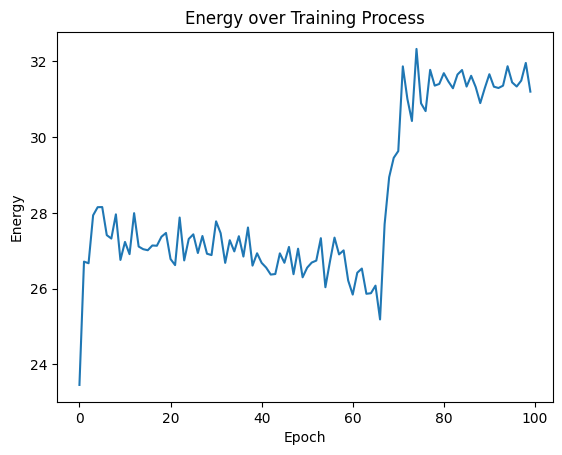

In [201]:
plt.plot(energies)
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.title('Energy over Training Process')
plt.show()

In [202]:
model(torch.tensor(stateTable[0].reshape(1,1,a,b),dtype=torch.float,requires_grad=True))**2

tensor([[541.9844]], grad_fn=<PowBackward0>)

### Save Model

In [203]:
torch.save(model.state_dict(), PATH + '/'+str(a)+'x'+str(b)+'model.pth')
print("Model saved.")

Model saved.


### Load Model

In [204]:
state_dict = torch.load(PATH + '/'+str(a)+'x'+str(b)+'model.pth')
model.load_state_dict(state_dict,strict=False)

<All keys matched successfully>

### Compare Results

In [205]:
resultState = []
model.eval()
for i in tqdm.tqdm(range(N)):
    resultState.append(model(torch.tensor(stateTable[i].reshape(1,1,a,b), dtype=torch.float, requires_grad=True)).item())
resultState = np.array(resultState)
resultState /= np.linalg.norm(resultState)

  0%|          | 0/12870 [00:00<?, ?it/s]

100%|██████████| 12870/12870 [00:44<00:00, 286.67it/s]


In [206]:
if a == 4 and b == 4:
    trueState = np.load(PATH+'/4x4groundstate.npy')

    if np.sum((resultState-trueState)**2) > np.sum((resultState+trueState)**2): resultState *= -1

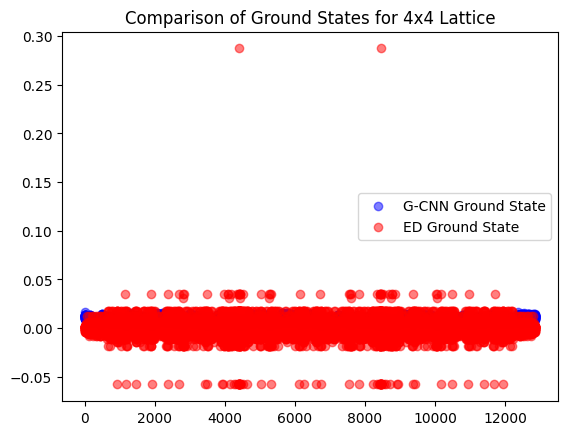

1.9993605474095524


In [207]:
if a == 4 and b == 4:
    plt.scatter(range(N),resultState, color="blue", label="G-CNN Ground State", alpha=0.5)
    plt.scatter(range(N),trueState, color="red", label="ED Ground State", alpha=0.5)
    plt.title("Comparison of Ground States for "+str(a)+"x"+str(b)+" Lattice")
    plt.legend()
    plt.show()

    error = np.sum((resultState-trueState)**2)
    print(error)